Responding to reviewer #1 point: Could the ligand-receptor interactions identified by Tensor-cell2cell be traced back to specific clusters in the dataset (for instance as cluster markers), thus identifying specific subpopulations as interacting?

In [188]:
import os

from collections import defaultdict
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from scipy.stats import spearmanr

import cell2cell as c2c

seed = 888
np.random.seed(seed)
data_path = '/data3/hratch/tc2c_analyses_1/natcomm_revisions/'

# Part 1: Visualize factor sender cell-ligand and receiver cell-receptor combinations

In [189]:
# same as '/results/COVID-19/BALF_tensor.pickle' in CodeOcean created in script 06 
with open(data_path + 'processed/BALF_tensor.pickle', 'rb') as handle:
    balf_tensor = pickle.load(handle)  

In [223]:
from typing import Union
import numpy as np
import pandas as pd

def get_joint_loadings(self, dim1: str, dim2: str, factor: Union[str,int]) -> pd.DataFrame:
    """Create the joint probability distribution between two tensor dimensions for a 
    given factor output from decomposition.
    
    Parameters
    ----------
    dim1 : str
        One of the tensor dimensions (options are self.factors.keys())
    dim2 : str
        A second tensor dimension (options are self.factors.keys())
    factor: Union[str,int]
        one of the factors output from decompositon [1, self.rank]
    
    Returns
    -------
    joint_dist : pd.DataFrame
        joint distribution of factor loadings for the specified dimensions. 
        Rows correspond to dim1 and columns to dim2
    """
    if dim1 not in self.factors:
        raise ValueError('The specified dimension ' + dim1 + ' is not present in the tensor')
    if dim2 not in self.factors:
        raise ValueError('The specified dimension ' + dim2 + ' is not present in the tensor')
    if int(factor) > list(self.factors.values())[0].shape[1]:
        raise ValueError('The specified factor lies outside the computed low-rank tensor')
    
    vec1 = self.factors[dim1]['Factor ' + str(factor)]
    vec2 = self.factors[dim2]['Factor ' + str(factor)]
    
    # calculate the outer product
    joint_dist = pd.DataFrame(np.outer(vec1, vec2), 
                              index = vec1.index, 
                              columns = vec2.index)

    return joint_dist

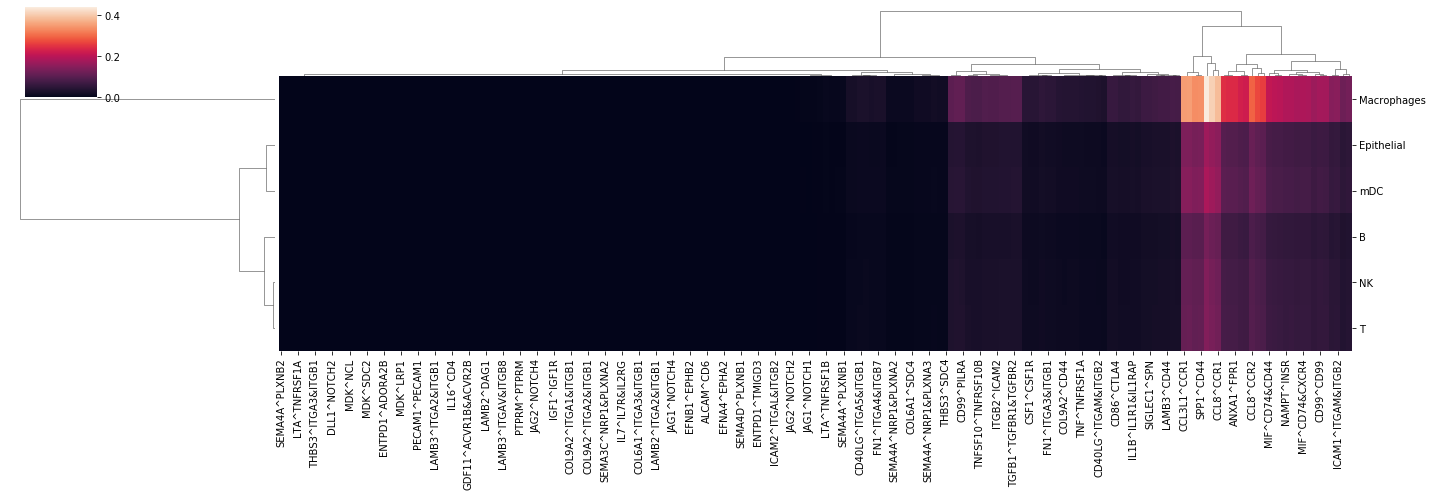

In [236]:
joint_dis_send = get_joint_loadings(balf_tensor, dim1 = 'LRs', dim2 = 'Sender', 
                              factor = 8)
g = sns.clustermap(joint_dis_send.T, figsize = (20,7))

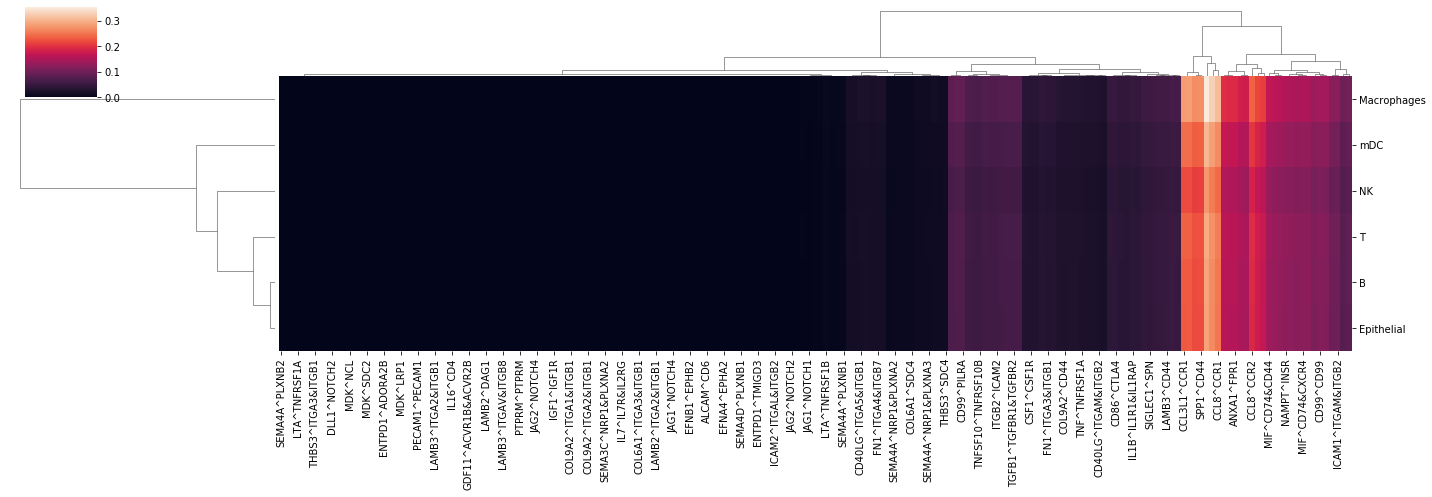

In [237]:
joint_dis_receive = get_joint_loadings(balf_tensor, dim1 = 'LRs', dim2 = 'Receiver', 
                              factor = 8)
g = sns.clustermap(joint_dis_receive.T, figsize = (20,7))

# Part 2: Canonical single-cell analysis to ID cell type markers

to do: marker analysis of severe covid macrophage ligands

compare DE results to factor 8 loadings

In [298]:
def load_samples(file):
    """Load each sample as an AnnData object."""
    sample = file.split('_')[1]
    adata = sc.read_10x_h5(data_path + 'raw/BALF/' + file) 
    adata.var_names_make_unique()
    
    # add metadata information
    sample_md = meta[meta['sample'] == sample]
    sample_md.index = sample_md.ID.apply(lambda x: x.split('_')[0])
    adata.obs.index = pd.Series(adata.obs.index).apply(lambda x: x.split('-')[0]).tolist()
    intersect_cells = list(set(sample_md.index).intersection(adata.obs.index))
    adata = adata[intersect_cells, :]
    adata.obs = pd.concat([adata.obs, sample_md.loc[intersect_cells,:]], axis = 1)
    
    return sample, adata

def process_data(adata, min_cells = 4, n_pcs = 100):
    sc.pp.filter_genes(adata, min_cells=min_cells) # filter for genes detected in > 3 cells as in script COVID-19/05-
    adata.var['mt'] = adata.var_names.str.startswith('MT-') # get mitochondrial fraction
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pp.normalize_total(adata, target_sum=1e6) # CPM normalize
    sc.pp.log1p(adata) # log scale

    # HVGs
#     sc.pp.highly_variable_genes(adata) # get HVGs
#     adata.raw = adata # save full dataset before filtering for HVGs
#     adata = adata[:, adata.var.highly_variable] # filter for HVGs

#     sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) # regress out effects
#     sc.pp.scale(adata, max_value=10) # scale to unit variance

#     sc.tl.pca(adata, n_comps = n_pcs, svd_solver='arpack', random_state = seed) # run PCA
#     sc.pp.neighbors(adata, n_pcs = n_pcs)
#     sc.tl.umap(adata)
    return adata

def jaccard(x,y):
    return len(set(x).intersection(y))/len(set(x + y))

In [ ]:
files = os.listdir(data_path + 'raw/BALF/') # this is same as '/data/COVID-19/' in CodeOcean
# expr_files = [f for f in files if f.endswith('.h5')]

meta = pd.read_csv(data_path + 'raw/BALF/metadata.txt', sep = '\t')

# filter for sever samples
meta = meta[meta.group == 'S']
expr_files = [f for f in files if f.endswith('.h5') and\
             f.split('_')[1] in meta['sample'].unique()] # severe samples only 
cell_type_map = dict(zip(meta.ID.apply(lambda x: '-'.join(x.split('_'))), meta.celltype))

In [299]:
# load the samples
data = {}
for file in tqdm(expr_files[:2]):
    sample, adata = load_samples(file)
    data[sample] = adata

# merge the samples
adata = sc.concat(data.values()) 
adata.obs_names_make_unique()

# log-normalize 
adata = process_data(adata)

  0%|          | 0/2 [00:00<?, ?it/s]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 50%|█████     | 1/2 [00:03<00:03,  3.15s/it]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
100%|██████████| 2/2 [00:05<00:00,  2.51s/it]
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [345]:
# get the LR pairs present in the dataset
lr_pairs = balf_tensor.order_names[1]
ligands = list(set([lr.split('^')[0] for lr in lr_pairs]))
# filter for ligands only to test 
adata_l = adata[:, ligands]
adata_l.raw = adata_l

# do DE
sc.tl.rank_genes_groups(adata_l, groupby = 'celltype', method='t-test', 
                       corr_method = 'benjamini-hochberg')
de_res = pd.DataFrame(data = {'fdr' : list(adata_l.uns['rank_genes_groups']['pvals_adj']['Macrophages']),
                     'lfc' : list(adata_l.uns['rank_genes_groups']['logfoldchanges']['Macrophages'])},
             index = list(adata_l.uns['rank_genes_groups']['names']['Macrophages']))
print('{} of {} ligands are differentially expressed'.format(\
                                                        de_res[de_res.fdr < 0.1].shape[0],
                                                        de_res.shape[0]))

86 of 92 ligands are differentially expressed


In [347]:
de_res['de_rank'] = list(range(de_res.shape[0]))

# sort factor 8 loadings
f8_loadings = balf_tensor.factors['LRs']['Factor 8'].sort_values(ascending = False)

# filter for ligand portion
ranked_ligands = pd.Series(f8_loadings.index).apply(lambda x: x.split('^')[0]).tolist()
# select first occurence of ligand
ranked_ligands_dict = defaultdict(list)
for i,l in enumerate(ranked_ligands):
    ranked_ligands_dict[l].append(i)
ranked_ligands_dict = {k: min(v) for k,v in ranked_ligands_dict.items()}
de_res['loadings_rank'] = de_res.index.map(ranked_ligands_dict)

In [392]:
sig_de = de_res[de_res.fdr<0.1]
r1 = spearmanr(de_res.de_rank, de_res.loadings_rank)
r2 = spearmanr(sig_de.de_rank, sig_de.loadings_rank)

print('The spearman correlation between DE ligands and Factor 8 ligand loadings is {:.2f} (pval = {:.2E})'.format(r1[0], r1[1]))
print('The spearman correlation between DE ligands and Factor 8 ligand loadings, filtered for significant genes, is {:.2f} (pval = {:.2E})'.format(r2[0], r2[1]))

The spearman correlation between DE ligands and Factor 8 ligand loadings is 0.53 (pval = 4.08E-08)
The spearman correlation between DE ligands and Factor 8 ligand loadings, filtered for significant genes, is 0.55 (pval = 4.17E-08)


In [432]:
# calculate concordance using jaccard 

de_rank_all = de_res.de_rank.sort_values(ascending = True).index.tolist()
loadings_rank_all = de_res.loadings_rank.sort_values(ascending = True).index.tolist()
concordance = []
for i in range(1, de_res.shape[0] + 1):
    concordance.append(jaccard(de_rank_all[:i], loadings_rank_all[:i]))
de_res['concordance'] = concordance

# same but for just significant genes

de_rank_sig = sig_de.de_rank.sort_values(ascending = True).index.tolist()
loadings_rank_sig = sig_de.loadings_rank.sort_values(ascending = True).index.tolist()
concordance = []
for i in range(1, sig_de.shape[0] + 1):
    concordance.append(jaccard(de_rank_sig[:i], loadings_rank_sig[:i]))
sig_de['concordance'] = concordance

<ipython-input-432-f71a17b57547>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_de['concordance'] = concordance


In [433]:
de_res['n_genes'] = list(range(1, de_res.shape[0] + 1))
sig_de['n_genes'] = list(range(1, sig_de.shape[0] + 1))

<ipython-input-433-24d5fe3e6602>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_de['n_genes'] = list(range(1, sig_de.shape[0] + 1))


''

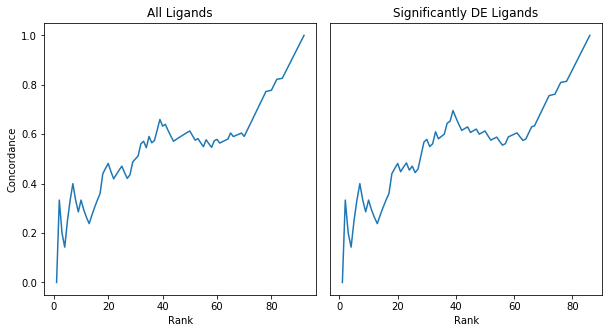

In [444]:
fig, ax = plt.subplots(figsize = (10,5), ncols=2)
g1 = sns.lineplot(data = de_res, x = 'n_genes', y = 'concordance', ax = ax[0])
g2 = sns.lineplot(data = sig_de, x = 'n_genes', y = 'concordance', ax = ax[1])

for i in range(2):
    ax[i].set_xlabel('Rank')
    ax[i].set_ylabel('Concordance')
ax[0].set_title('All Ligands')
ax[1].set_title('Significantly DE Ligands')
ax[1].set_ylabel('')
ax[1].set_yticks([])
fig.subplots_adjust(wspace = 0.05)
;